In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
# dataset generation

def perpelixy

In [3]:
def generate_task_subsets(num_tasks, num_bits, task_sizes, random_state = 0):
  np.random.seed(random_state)
  task_subsets = np.zeros((num_tasks, num_bits))
  for i in range(num_tasks):
    task_subsets[i][np.random.choice(num_bits, size = task_sizes[i], replace = False)] = 1
  return task_subsets

def create_dataset(num_tasks, num_bits, task_freq, task_subsets, num_samples, num_batches = 1, random_state = 0):
  np.random.seed(random_state)
  # generate task-subsets
  # task_subsets = np.zeros((num_tasks, num_bits))
  # for i in range(num_tasks):
  #   task_subsets[i][np.random.choice(num_bits, size = task_sizes[i], replace = False)] = 1
  # print("task subsets")
  # print(task_subsets)
  all_tasks = np.arange(num_tasks)

  for i in range(num_batches):
    # sample tasks
    tasks = np.random.choice(all_tasks, size = num_samples, p = task_freq / task_freq.sum())

    # generate control bits with respect to task frequencies
    control_bits = np.eye(num_tasks)[tasks]
    # print("control bit shapes")
    # print(control_bits)
    # print(control_bits.shape)

    # generate task strings
    task_bits = np.random.randint(2, size = (num_samples, num_bits))
    # print("task bit shapes")
    # print(task_bits)
    # print(task_bits.shape)

    # generate output strings
    task_masks = task_subsets[tasks]
    # print("task mask shapes")
    # print(task_masks)
    # print(task_masks.shape)
    
    out = np.sum(task_bits * task_masks, axis = 1) % 2
    input = np.concatenate([control_bits, task_bits], axis = 1)
    # print(input.shape)

    yield input, out

In [4]:
[x for x in create_dataset(2, 4, np.array([1, 1]), generate_task_subsets(2, 4, np.array([1, 4])), num_samples = 3, num_batches = 2)]

[(array([[0., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0.]]),
  array([0., 0., 0.])),
 (array([[1., 0., 0., 1., 1., 1.],
         [0., 1., 1., 0., 1., 0.],
         [0., 1., 1., 0., 1., 1.]]),
  array([1., 0., 1.]))]

# Trying to train one model to reproduce results in paper

In [5]:
batches = 10000
num_tasks = 100
n = 100
alpha = 0.4

mlp = nn.Sequential(
    nn.Linear(num_tasks + n, 500),
    nn.ReLU(),
    nn.Linear(500, 2)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr = 1e-3)
loss_func = nn.CrossEntropyLoss(reduction = "mean")

# power law scaling with uniform task hardness
# power_law = (np.arange(num_tasks) + 1) ** (-alpha - 1)
# power_law = power_law / power_law.sum()
# task_subsets = generate_task_subsets(num_tasks, n, np.ones(num_tasks, int) * 3)
# train_data = create_dataset(500, 100, power_law, task_subsets, 20000, batches)

# uniform frequency, varied task hardness
frequencies = np.ones(num_tasks)
frequencies = frequencies / frequencies.sum()
subset_sizes = np.arange(100)
task_subsets = generate_task_subsets(num_tasks, n, subset_sizes)
train_data = create_dataset(num_tasks, n, frequencies, task_subsets, 20000, batches)

# test_data = [x for x in create_dataset(500, 100, power_law, task_subsets, 2000, 1, 1)][0]

In [7]:
mlp[0]

Linear(in_features=200, out_features=500, bias=True)

In [ ]:
losses = []
big_losses = []

In [ ]:
def eval_subtasks(model, task_subsets, loss_func, samples_per_task = 50):
  n_tasks = task_subsets.shape[0]
  n = task_subsets.shape[1]

  task_bits = np.random.randint(2, size = (samples_per_task * n_tasks, n))
  output_bits = np.zeros(samples_per_task * n_tasks, dtype = int)
  # create outputs for every subtask
  for i in range(n_tasks):
    input_slice = task_bits[i * samples_per_task : (i + 1) * samples_per_task]
    outputs = np.sum(input_slice * task_subsets[i], axis = 1) % 2
    output_bits[i * samples_per_task:(i + 1) * samples_per_task] = outputs
  input_bits = np.eye(n_tasks)[np.repeat(np.arange(n_tasks), samples_per_task)]
  # print(input_bits.shape)

  total_input = np.concatenate([input_bits, task_bits], axis = 1)
  # calculate the loss for each (in bits)
  mod_outputs = model(torch.from_numpy(total_input).float().cuda())
  loss = loss_func(mod_outputs, torch.from_numpy(output_bits).long().cuda())
  # print(loss.shape)
  # return loss in bits for every subtask
  loss = loss.cpu()

  losses = loss.reshape(-1, samples_per_task).mean(axis = 1) / np.log(2)
  # print(losses.shape)
  return losses


In [ ]:
for i, (x, y) in enumerate(train_data):
  print(f"Batch {i}")
  mlp.train()
  mlp.cuda()
  optimizer.zero_grad()

  x, y = torch.from_numpy(x).float().cuda(), torch.from_numpy(y).long().cuda()
  outputs = mlp(x)
  loss = loss_func(outputs, y)
  loss.backward()
  losses.append(loss.item())
  optimizer.step()

  if i % 5 == 0:
    mlp.eval()
    with torch.no_grad():
      big_losses.append(eval_subtasks(mlp, task_subsets, nn.CrossEntropyLoss(reduction = 'none'), 100))


Streaming output truncated to the last 5000 lines.
Batch 5000
Batch 5001
Batch 5002
Batch 5003
Batch 5004
Batch 5005
Batch 5006
Batch 5007
Batch 5008
Batch 5009
Batch 5010
Batch 5011
Batch 5012
Batch 5013
Batch 5014
Batch 5015
Batch 5016
Batch 5017
Batch 5018
Batch 5019
Batch 5020
Batch 5021
Batch 5022
Batch 5023
Batch 5024
Batch 5025
Batch 5026
Batch 5027
Batch 5028
Batch 5029
Batch 5030
Batch 5031
Batch 5032
Batch 5033
Batch 5034
Batch 5035
Batch 5036
Batch 5037
Batch 5038
Batch 5039
Batch 5040
Batch 5041
Batch 5042
Batch 5043
Batch 5044
Batch 5045
Batch 5046
Batch 5047
Batch 5048
Batch 5049
Batch 5050
Batch 5051
Batch 5052
Batch 5053
Batch 5054
Batch 5055
Batch 5056
Batch 5057
Batch 5058
Batch 5059
Batch 5060
Batch 5061
Batch 5062
Batch 5063
Batch 5064
Batch 5065
Batch 5066
Batch 5067
Batch 5068
Batch 5069
Batch 5070
Batch 5071
Batch 5072
Batch 5073
Batch 5074
Batch 5075
Batch 5076
Batch 5077
Batch 5078
Batch 5079
Batch 5080
Batch 5081
Batch 5082
Batch 5083
Batch 5084
Batch 5085
Bat

In [ ]:
import matplotlib.pyplot as plt

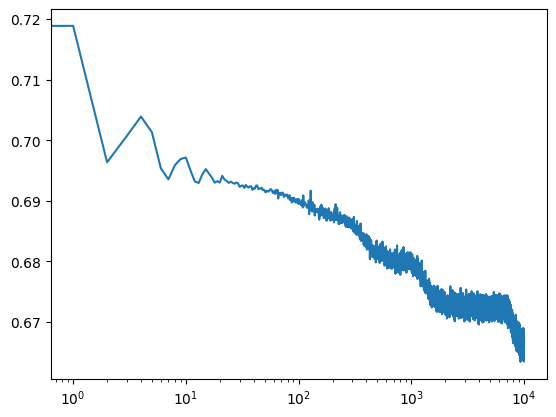

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.xscale("log")

In [ ]:
big_losses = np.array([bl.numpy() for bl in big_losses])

In [ ]:
big_losses.shape

(2000, 100)

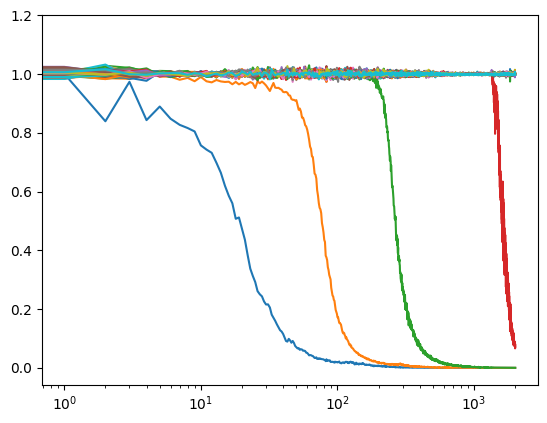

In [ ]:
for i in range(100):
  plt.plot(range(big_losses.shape[0]), big_losses[:, i])
plt.xscale("log")